# SHARK QUEST
## New Kids On The Block



TODO : 
- change df name


In [2125]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2126]:
# Import depedencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cleaning import *

In [2127]:
# Settings
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 100)

In [2128]:
# Load the data
sources = get_json('sources');

raw_data = load_data(sources['principal'])
shark_attacks = raw_data.copy()

In [2129]:
# Data Contract
data_schema = get_json('schema')

In [2130]:
# Rename all columns according to the data schema
shark_attacks = rename_columns(shark_attacks, data_schema)

In [2131]:
# Add new columns from the data schema
add_columns(shark_attacks, data_schema)

In [2132]:
# Drop columns that are not in the schema
shark_attacks = drop_columns(shark_attacks, data_schema)

In [2133]:
# Strip strings
shark_attacks = shark_attacks.apply(lambda x: x.str.strip() if x.dtype == ['object', 'string'] else x)

In [2134]:
# Handling missing values
shark_attacks = shark_attacks.replace(['N/A', 'null', '--'], np.nan)

In [2135]:
# Remove duplicates
shark_attacks.drop_duplicates(keep=False, inplace=True)

shark_attacks = remove_duplicates(shark_attacks, data_schema)

In [2136]:
# Reset Index
shark_attacks.reset_index(inplace=True)

In [2137]:
# Reformat values
replacements = get_json('replacements')

shark_attacks = reformat_values(shark_attacks, replacements)

In [2138]:
# Validate from list, check if the values in the columns are in the list of valid values, if not, cast them to NaN
""" def validate_from_list(df, schema):
        
        for column, parameters in schema.items():
            if parameters.get('valid_values'):
                df.loc[~df[column].isin(parameters['valid_values']), column] = np.nan
                
        return df """

" def validate_from_list(df, schema):\n        \n        for column, parameters in schema.items():\n            if parameters.get('valid_values'):\n                df.loc[~df[column].isin(parameters['valid_values']), column] = np.nan\n                \n        return df "

In [2139]:
# Reformat country
#shark_attacks['country'] = shark_attacks['country'].apply(lambda x: x.lower() if isinstance(x, str) else x)
""" replace_to_nan(shark_attacks["country"], ["england","scotland"], "united kingdom")
replace_to_nan(shark_attacks["country"], ["usa", "hawaii"], "united states")
replace_to_nan(shark_attacks["country"], ["reunion"], "france")
replace_to_nan(shark_attacks["country"], ["columbia"], "colombia")
replace_to_nan(shark_attacks["country"], ["new guinea"], "papua new guinea") """


# unify country, converts all low value "country" ocorrences into <NA>. Also sets Country as string-type
""" shark_attacks["country"] = shark_attacks["country"].where(shark_attacks["country"].isin(country_list), np.nan) """

' shark_attacks["country"] = shark_attacks["country"].where(shark_attacks["country"].isin(country_list), np.nan) '

In [2140]:
# Clean dates
shark_attacks = clean_dates(shark_attacks, data_schema)

In [2141]:
# Cast correct types
columns_types = {key: value['dtype'] for key, value in data_schema.items()}
shark_attacks = shark_attacks.astype(columns_types)

In [2142]:
# Apply the function to the shark_attacks dataframe
shark_attacks = clean_categories(shark_attacks, data_schema, sources)

NameError: name 'sources' is not defined

In [2111]:
# Add helper columns
shark_attacks['severity_score'] = shark_attacks['severity'].apply(lambda x: 3 if x == 'FATALITY' else 2 if x == 'INJURY' else 1)

In [2112]:
# Clean copy for analysis
shark_attacks_clean = shark_attacks.copy()
shark_attacks_clean

,index,date,type,country,state,location,activity,sex,severity,time,species,severity_score
0,0,2024-01-03,UNPROVOKED,s,Queensland,Bargara Beach,SWIMMING,FEMALE,INJURY,AFTERNOON,TIGER SHARK,2
1,1,2024-01-03,UNPROVOKED,s,Hawaii,"Old Man's, Waikiki",SURFING,MALE,INJURY,UNKNOWN,TIGER SHARK,2
2,2,2024-01-03,UNPROVOKED,s,Hawaii,"Rainbows, Oahu",SWIMMING,FEMALE,INJURY,NOON,MYSTERY SHARK,2
3,3,2024-01-02,UNPROVOKED,s,Western Australia,"Sandlnd Island, Jurian Bay",PASSIVE,FEMALE,INJURY,NOON,TIGER SHARK,2
4,4,2024-01-02,UNPROVOKED,s,Maharashtra,"Vaitarna River, Palghar District",FISHING,MALE,INJURY,UNKNOWN,BULL SHARK,2
...,...,...,...,...,...,...,...,...,...,...,...,...
6800,6939,1913-01-07,UNPROVOKED,s,Western Australia,Roebuck Bay,DIVING,MALE,FATALITY,UNKNOWN,MYSTERY SHARK,3
6801,6940,1913-01-07,UNPROVOKED,s,Western Australia,<NA>,DIVING,MALE,FATALITY,UNKNOWN,MYSTERY SHARK,3
6802,6941,1913-01-07,UNPROVOKED,s,North Carolina,Ocracoke Inlet,SWIMMING,MALE,FATALITY,UNKNOWN,MYSTERY SHARK,3
6803,6942,1913-01-07,UNPROVOKED,s,<NA>,"Panama Bay 8ºN, 79ºW",PASSIVE,MALE,FATALITY,UNKNOWN,MYSTERY SHARK,3


# ANALYSIS

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/3300347951.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Time Category', y='Number of Attacks', data=df_time, palette='Blues')


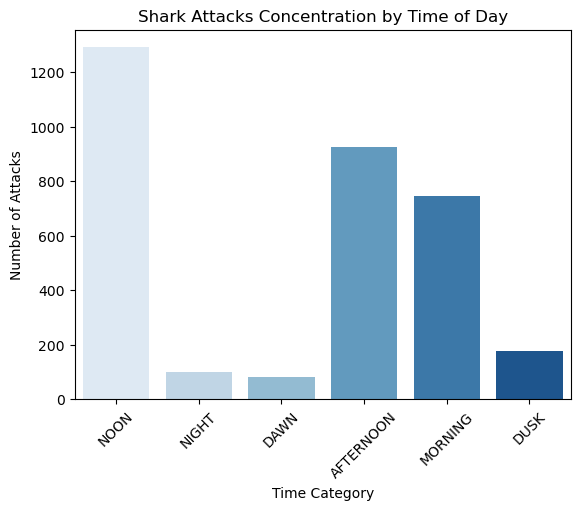

In [2113]:
#Hypothesis: Shark attacks are more concentrated in the PM 
time_stats = shark_attacks['time'].cat.remove_categories('UNKNOWN')

time_counts = time_stats.value_counts()
time_counts


df_time = pd.DataFrame(
    {'Time Category': time_counts.index,
     'Number of Attacks': time_counts.values  
    }
)
df_time
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='Time Category', y='Number of Attacks', data=df_time, palette='Blues')
plt.title('Shark Attacks Concentration by Time of Day')
plt.xlabel('Time Category')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.show()

#Conclusion: we could easily determine that shark attacks are most concentrated during NOON based on the dataset.

# HYPOTHESIS: SOME SHARK SPECIES ARE MORE DANGEROUS THAN OTHERS

In [2114]:
#group by species and severity score, count occurences for each species
species_severity_count = shark_attacks_clean.groupby(['species', 'severity_score']).size().unstack(fill_value=0)

#drop MYSTERY SHARK row
species_severity_count = species_severity_count.drop("MYSTERY SHARK")

#reorder the columns
severity_order = [1, 2, 3]
species_severity_count = species_severity_count[severity_order]


#calculate the percentage
total_counts = species_severity_count.sum(axis=1)

percentage_severity = species_severity_count.div(total_counts, axis=0) * 100


#Filter out low incidence species
species_with_high_counts = total_counts[total_counts > 15].index

filtered_species = percentage_severity.loc[species_with_high_counts]

#convert to string so seaborn correctly filters out dropped species
filtered_species.index = filtered_species.index.astype(str)


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/861426949.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  species_severity_count = shark_attacks_clean.groupby(['species', 'severity_score']).size().unstack(fill_value=0)


In [2115]:
#sort by occurence of FATALITY
sorted_by_category_3 = filtered_species.sort_values(by=3, ascending=False)

top_severity_3 = sorted_by_category_3.head(6)
top_severity_3

severity_score,1,2,3
species,,,
ZAMBEZI SHARK,10.000000,60.000000,30.000000
TIGER SHARK,9.696970,66.666667,23.636364
GREAT WHITE SHARK,17.886179,59.214092,22.899729
BULL SHARK,2.336449,78.504673,19.158879
BLUE SHARK,13.333333,70.000000,16.666667
WHALER SHARK,21.794872,70.512821,7.692308


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/1255495480.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_severity_3[3], y=top_severity_3['species'], palette='viridis')


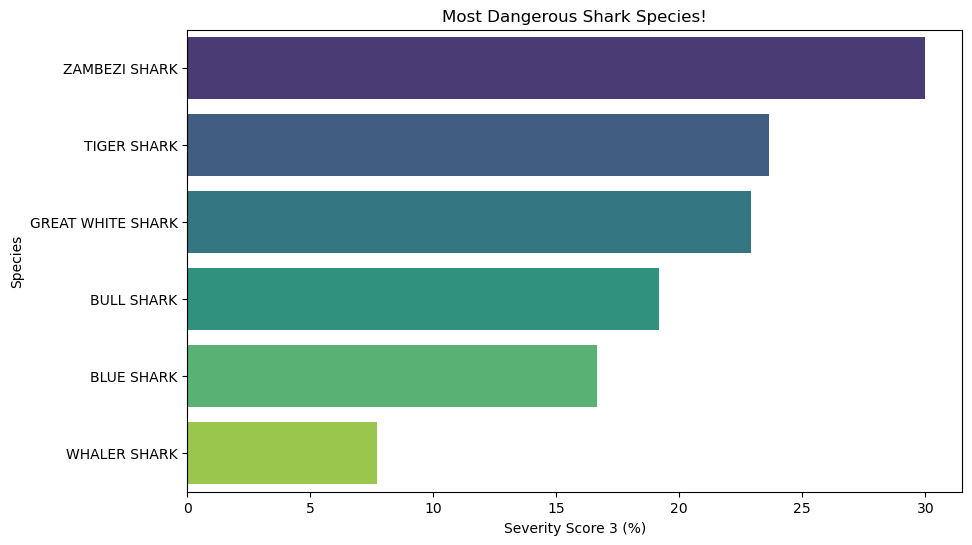

In [2116]:
#MOST DANGEROUS SHARK SPECIES VISUALISATION

import seaborn as sns


top_severity_3 = top_severity_3.reset_index()

# Create Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_severity_3[3], y=top_severity_3['species'], palette='viridis')

plt.title('Most Dangerous Shark Species!')
plt.xlabel('Severity Score 3 (%)')
plt.ylabel('Species')

plt.show()

In [2117]:
#sort by occurence of NO-INJURY
top_severity_1 = filtered_species.sort_values(by=1, ascending=False)

#filter for lower than 5% fatality rate:
top_severity_1_notdeadly = top_severity_1[top_severity_1[3]<5].head(6)
display(top_severity_1_notdeadly)

severity_score,1,2,3
species,,,
HAMMERHEAD SHARK,22.916667,72.916667,4.166667
MAKO SHARK,22.807018,73.684211,3.508772
SEVENGILL SHARK,18.181818,81.818182,0.000000
NURSE SHARK,10.714286,88.392857,0.892857
RAGGEDTOOTH SHARK,9.302326,90.697674,0.000000
WOBBEGONG SHARK,7.547170,92.452830,0.000000


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/144674034.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_severity_1_notdeadly[1], y=top_severity_1_notdeadly['species'], palette='viridis')


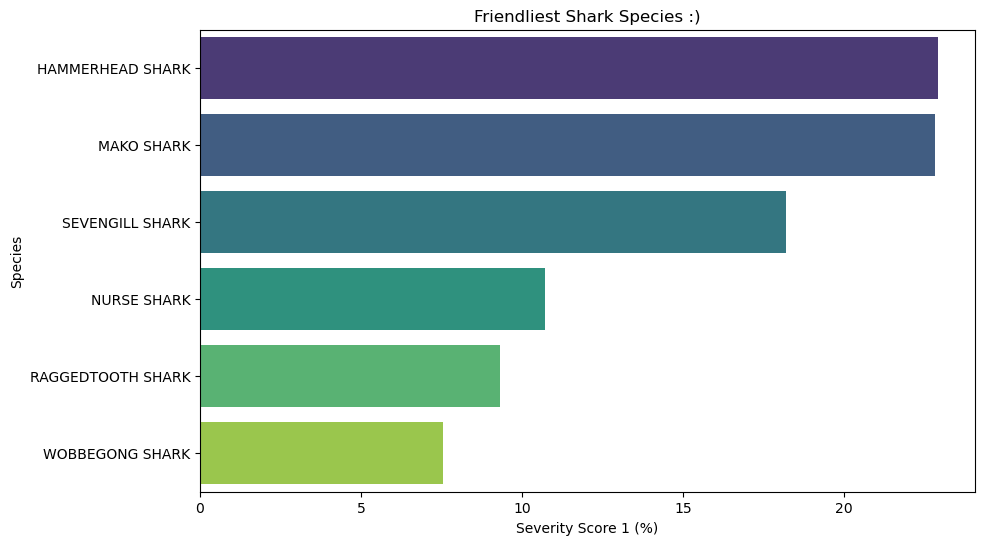

In [2118]:
#FRIENDLIEST SHARK SPECIES VISUALISATION

top_severity_1_notdeadly = top_severity_1_notdeadly.reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x=top_severity_1_notdeadly[1], y=top_severity_1_notdeadly['species'], palette='viridis')

plt.title('Friendliest Shark Species :)')
plt.xlabel('Severity Score 1 (%)')
plt.ylabel('Species')

plt.show()

# HYPOTHESIS: SOME COUNTRIES HAVE HIGHER PROVOKED / TOTAL ATTACK RATIO

In [2119]:
## working with the clean dataframe instead of main, clearing unused information
sa_clean = shark_attacks_clean[["date", "time", "country", "state", "location", "type", "severity"]].copy()

In [2120]:
## FUNCTIONS REQUIRED, to be sent to a different file


def group_and_filter_by_type(df, groupby_cols, attack_type=None, count_threshold=0):
    
    """
    Groups the DataFrame by specified columns and applies filter conditions.

    Parameters:
    - df: The DataFrame to group and filter
    - groupby_cols: List of columns to group by
    - filter_conditions: A dictionary containing column names and their corresponding filter conditions
    
    Returns:
    - A filtered DataFrame grouped by specified columns with a 'count' column
    """
     # Group by the specified columns and calculate the count of each group
    grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
    
    # Apply the count filter
    grouped_df = grouped_df[grouped_df['count'] > count_threshold]
    
    # Apply the type filter if attack_type is provided
    if attack_type:
        grouped_df = grouped_df[grouped_df['type'] == attack_type]

    return grouped_df

def clean_merge_and_plot(p_sa, up_sa, merge_on="country", provoked_col="count_x", unprovoked_col="count_y", drop_columns=None):
    """
    Merges two dataframes, calculates totals and provoked/unprovoked ratios, and visualizes results.

    Parameters:
    - p_sa: DataFrame for provoked attacks
    - up_sa: DataFrame for unprovoked attacks
    - merge_on: Column name to merge on (default: 'country')
    - provoked_col: Column name for provoked counts (default: 'count_x')
    - unprovoked_col: Column name for unprovoked counts (default: 'count_y')
    - drop_columns: list of column names to drop, default None
    
    Returns:
    - A DataFrame sorted by the provoked/unprovoked ratio
    - A seaborn plot showing the ratio of provoked attacks by country
    """
    # Merge the dataframes
    merged_df = pd.merge(
        left=p_sa,
        right=up_sa,
        on=merge_on,
        how='inner'
        ).reset_index(drop=True).rename(
                                        columns={
                                            provoked_col: "provoked",
                                            unprovoked_col: "unprovoked"
                                            }
                                        )
    
    # Calculate total and ratio directly on columns (vectorized)
    merged_df["total"] = merged_df["provoked"] + merged_df["unprovoked"]
    merged_df["ratio"] = (merged_df["provoked"] / merged_df["total"] * 100).round(2)

    # Sort by the 'ratio' column in descending order
    merged_df = merged_df.sort_values(by="ratio", ascending=False).reset_index(drop=True)

    # Drop columns if provided
    if drop_columns:
        columns_to_drop = [col for col in drop_columns if col in merged_df.columns]
        merged_df = merged_df.drop(columns=columns_to_drop)

    # Print the cleaned DataFrame
    #display(merged_df)

    # Plotting the ratio of provoked attacks by country
    sns.catplot(data=merged_df, kind="bar", x=merge_on, y="ratio", hue="total")
    plt.xticks(rotation=90)
    plt.ylabel("Provoked / Total attacks")
    plt.tight_layout()
    plt.show()

    return merged_df


/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/2526044317.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/2526044317.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/2526044317.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

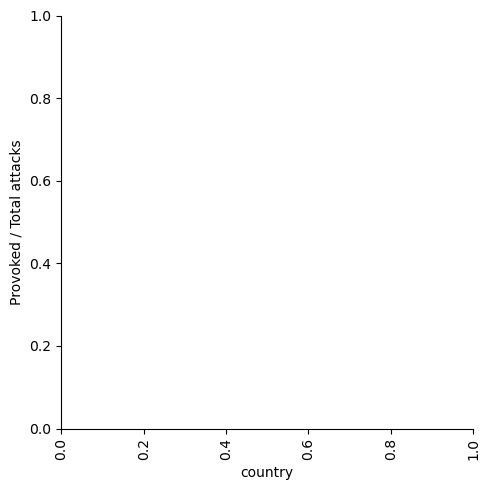

,country,type_x,provoked,type_y,unprovoked,total,ratio


In [2121]:
#### whole-time overview

# Converts country to lowercase    
sa_clean["country"] = sa_clean["country"].apply(lambda x: x.lower() if isinstance(x,str) else x)

# introduces country sheet. Converts into a list  ### Convert into dictionary, pass it through repnan or JP's
replace_to_nan(sa_clean["country"], ["england","scotland", "cayman islands", "bermuda", "british virgin islands", "british overseas territory"], "united kingdom")
replace_to_nan(sa_clean["country"], ["usa", "hawaii"], "united states of america")
replace_to_nan(sa_clean["country"], ["reunion"], "france")
replace_to_nan(sa_clean["country"], ["columbia"], "colombia")
replace_to_nan(sa_clean["country"], ["new guinea"], "papua new guinea")

# unify country, converts all low value "country" ocorrences into <NA>. Also sets Country as string-type
sa_clean["country"] = sa_clean["country"].where(sa_clean["country"].isin(country_list)).astype("string")

# this should replace all the bottom part
provoked_sa_country_type = group_and_filter_by_type(sa_clean, ["country", "type"], attack_type="PROVOKED", count_threshold=3)
unprovoked_sa_country_type = group_and_filter_by_type(sa_clean, ["country", "type"], attack_type="UNPROVOKED", count_threshold=4)
watercraft_sa_country_type = group_and_filter_by_type(sa_clean, ["country", "type"], attack_type="WATERCRAFT", count_threshold=0)

clean_merge_and_plot(provoked_sa_country_type, unprovoked_sa_country_type, merge_on="country", provoked_col="count_x", unprovoked_col="count_y", drop_columns=None)

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/2526044317.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/2526044317.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/2526044317.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

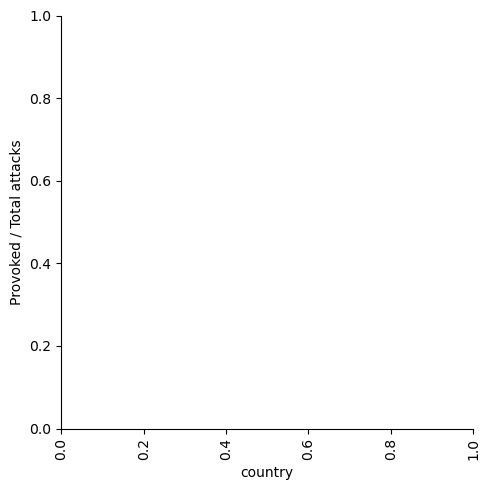

,country,provoked,unprovoked,total,ratio


In [2122]:
###### Lets try to get last 50yrs
date_start = "01-01-1975"
date_start= pd.to_datetime(date_start, format='%d-%m-%Y')
sa_clean["date"] = sa_clean["date"].astype('datetime64[ns]')

# Makes a new database with only last 50yrs score (start jan-1)    
sa_clean_new = sa_clean[sa_clean['date'] > (date_start)].copy()

# Apply the group_and_filter function to get the respective DataFrames
p_sa_country_type_new = group_and_filter_by_type(sa_clean_new, ["country", "type"], attack_type="PROVOKED", count_threshold=2)
up_sa_country_type_new = group_and_filter_by_type(sa_clean_new, ["country", "type"], attack_type="UNPROVOKED", count_threshold=4)
wc_sa_country_type_new = group_and_filter_by_type(sa_clean_new, ["country", "type"], attack_type="WATERCRAFT")

# Plots the info based on clean and merge function
clean_merge_and_plot(p_sa_country_type_new, up_sa_country_type_new, drop_columns=["type_x", "type_y"])

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/2526044317.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(groupby_cols).size().reset_index(name='count')
/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_93588/1958761944.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = sa_sev.groupby('type')['count'].sum().reset_index(name='total_count')


,type,severity,count,total_count,percentage
0,PROVOKED,FATALITY,15,630,2.380952
1,PROVOKED,OTHER,75,630,11.904762
2,PROVOKED,INJURY,540,630,85.714286
3,WATERCRAFT,FATALITY,12,362,3.314917
4,WATERCRAFT,OTHER,200,362,55.248619
5,WATERCRAFT,INJURY,150,362,41.436464
6,INVALID,FATALITY,71,594,11.952862
7,INVALID,OTHER,295,594,49.663300
8,INVALID,INJURY,228,594,38.383838
9,UNPROVOKED,FATALITY,1315,5219,25.196398


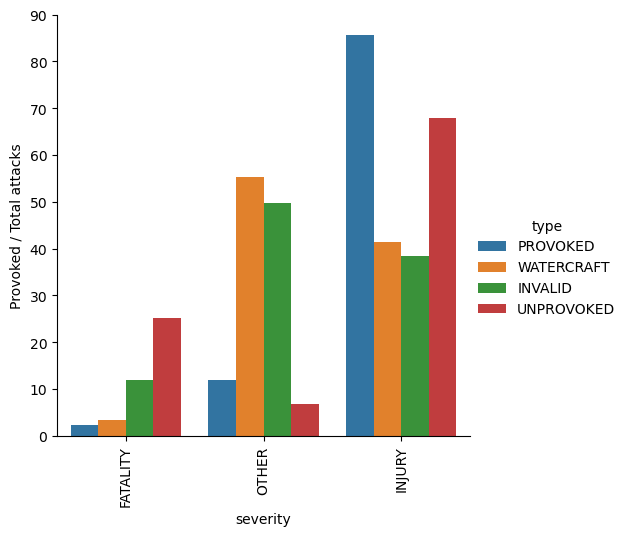

In [2123]:
## hipotesis: provoked attack have higher severity than unprovoked attacks // REBUKED

sa_sev = group_and_filter_by_type(sa_clean, ["type","severity"], attack_type=None, count_threshold=0)

#Calculates total counts for each type
total_counts = sa_sev.groupby('type')['count'].sum().reset_index(name='total_count')

#Merge total counts back 
sa_sev = sa_sev.merge(total_counts, on='type')

#Calculate percentage
sa_sev['percentage'] = (sa_sev['count'] / sa_sev['total_count']) * 100

# Display the result
display(sa_sev[['type', 'severity', 'count', 'total_count', 'percentage']])

sns.catplot(data=sa_sev, kind="bar", x="severity", y="percentage",hue="type")
plt.xticks(rotation=90)
plt.ylabel("Provoked / Total attacks")
plt.show()

# PLAN

In [2124]:
# Source, PDF, Case Number as possible duplicate finder or year / date fill

# Henning : Date, Type
# Ricardo : Country, State
# Linh : Location, Activity
# Jp : Injury, Time

# Type : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Provoked, Unprovoked, Invalid
# Date : datetime : Clean "Reported" - Harmonize Format - Cast weird into NaT. Final => Dates (as datetime), NaT
# Country : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# State : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Location : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Activity : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Few categories to be determined
# Injury : category : Merge columns based on keywords. Nan into other. Final => Fatality, Injury, Other
# Time : category : Cast into categories Final => morning (6-10) noon (10-14) afternoon( 14-18) dusk (18-22) night (22 - 2) dawn (2-6) maybe as integers (0-5)

# Todo
# Remove obvious duplicate (entire line) - Ricardo
# Remove fuzzy duplicates (case number? dates?) - Ricardo

# Functions :
# Merge categories : (*categories to be merged, target) - Henning
# Strip function : strips spaces - Linh
# Replace as Nan, Nat, ... function - Ricardo
# DONE - Replace by keyword function - Jp
# DONE - Cast to dateTime function
# Matching function (find similarities, keyword based?)
# DONE - Reformat dates, strings
# Filter function.

## Selecting
- Select relevant columns
- Analyse relevant columns

## Cleaning :
- Cast to appropriate data types
    - General cleaning
        - identify duplicates
            - fuzzy
        - removing duplicates
            - remove
            - merge
        - handling null values
            - remove
            - replace
        - manipulating strings
        - formatting the data.

- Wrong inputs
- Outliers

### GENERAL CLEANING
1. Rename columns
2. Drop columns
3. Remove duplicates
    - Remove full dupes
    - Remove fuzzy search
4. Strip values
5. Reset Index

### SPECIFIC CLEANING
1. Search / Replace / Reformat strings
2. Merge categories
3. Cast to Null
4. Cast correct type
5. Create new columns


## Hypothesis

### TIME
- Shark attacks are seasonal (Summer)
- Shark attacks are increasing 
- Shark attacks are more concentrated in the PM 

### LOCATION
- Some countries are more attack prone (Australia)
- Some countries are more likely to be fatal (Australia)


### DEMOGRAPHICS
- Males are more likely to get attacked
- Males are more likely to get provoke a shark
- Provoked attacked are more fatal
- Young persons are more likely to get attacked
- Old persons are more likely to get killed

- Names more likely to get attacked (John)

### OTHER
- Some species are more aggressive (Tiger Shark)
- Some activities are more likely (Surfing)
- Some activities are more fatal

- Full moon? 😂


Retained :
- Shark Species have a gender preference (score) => JP => Heinning
- Some countries are more provocative against sharks* => Ricardo
- Shark attacks are more concentrated in the PM => Linh

- Names more likely to get attacked (John) => JP?

## Business Ideas

- App that gives a likelyhood of attack based on location and time
- Vacations far away from sharks for phobics
- Witness attacks for masochists

- Surf school at the safest places / seasons
- Fishing supplies => shark repellant by activities
- Safety training to avoid provocations / live in harmony

- Shark repellant => best spots
- Insurance for surfers, premiums for high risk areas